Decision Tree accuracy: 0.986322188449848
Logistic Regression accuracy: 0.5835866261398176


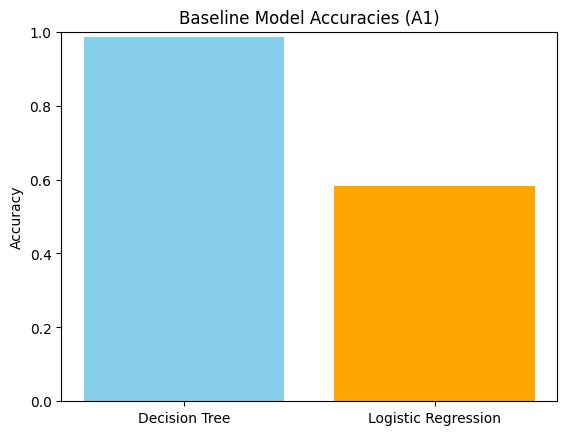

In [18]:
# A1: Train simple baseline models

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Load dataset
df12 = pd.read_csv("processed_fluency_dataset.csv")

# Function to convert "[number]" strings to float
def clean_number12(x):
    if isinstance(x, str) and x.startswith("[") and x.endswith("]"):
        return float(x.strip("[]").split(",")[0])
    return x

# Apply cleaning to all columns
for cols in df12.columns:
    df12[cols] = df12[cols].apply(clean_number12)

# Drop irrelevant columns
X12 = df12.drop(columns=["fluency","filename","student_id","type","fluency_encoded"])
y12 = df12["fluency"]

# Fill any missing numeric values with median
X12 = X12.fillna(X.median(numeric_only=True))

# Split data (train/test)
X_train, X_test, y_train, y_test = train_test_split(X12, y12, test_size=0.25, random_state=1)

# Train models
dt12 = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train)
lr12 = LogisticRegression(max_iter=500).fit(X_train, y_train)

print("Decision Tree accuracy:", dt12.score(X_test, y_test))
print("Logistic Regression accuracy:", lr12.score(X_test, y_test))

# ---- Visualization (plot only) ----
models = ["Decision Tree", "Logistic Regression"]
accs = [dt12.score(X_test, y_test), lr12.score(X_test, y_test)]
plt.bar(models, accs, color=["skyblue","orange"])
plt.ylabel("Accuracy")
plt.title("Baseline Model Accuracies (A1)")
plt.ylim(0,1)
plt.show()


Best Parameters: {'n_estimators': 200, 'max_depth': 10}
Best CV Score: 0.997970573313039
Test Accuracy: 1.0


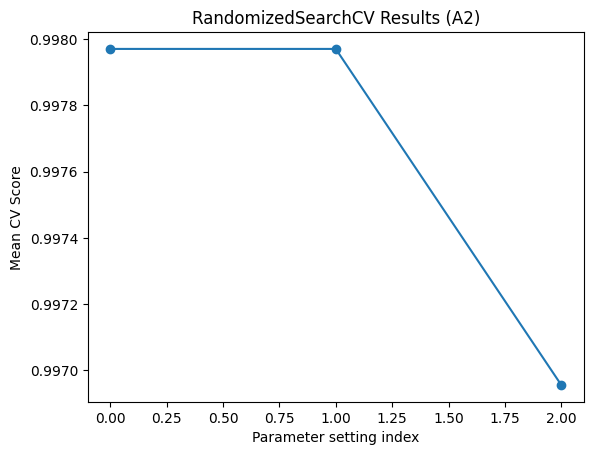

In [19]:
# A2: Hyperparameter tuning for RandomForest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import pandas as pd

rf12 = RandomForestClassifier(random_state=1)
params12 = {"n_estimators":[50,100,200],
          "max_depth":[None,5,10]}

search = RandomizedSearchCV(rf12, params12, n_iter=3, cv=3, random_state=1)
search.fit(X_train, y_train)

print("Best Parameters:", search.best_params_)
print("Best CV Score:", search.best_score_)
print("Test Accuracy:", search.best_estimator_.score(X_test, y_test))

# ---- Visualization (plot only) ----
cv_results = pd.DataFrame(search.cv_results_)
plt.plot(cv_results["mean_test_score"], marker="o")
plt.xlabel("Parameter setting index")
plt.ylabel("Mean CV Score")
plt.title("RandomizedSearchCV Results (A2)")
plt.show()


          Model     Train      Test
0  DecisionTree  0.980213  0.986322
1  RandomForest  1.000000  1.000000
2      AdaBoost  0.974125  0.963526
3    NaiveBayes  0.809741  0.816109
4           MLP  0.610857  0.583587


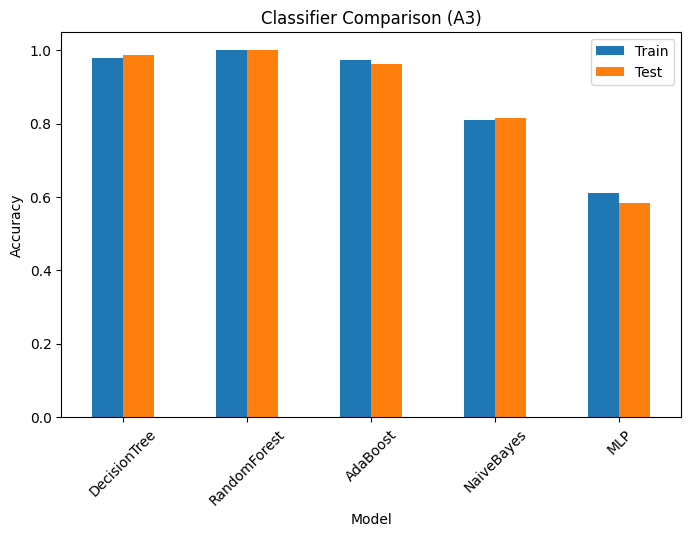

In [20]:
# A3: Compare different classifiers

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

models12 = {
    "DecisionTree": DecisionTreeClassifier(max_depth=5),
    "RandomForest": RandomForestClassifier(n_estimators=100),
    "AdaBoost": AdaBoostClassifier(),
    "NaiveBayes": GaussianNB(),
    "MLP": MLPClassifier(max_iter=300)
}

results12 = []
for name, model in models12.items():
    model.fit(X_train, y_train)
    results12.append({
        "Model": name,
        "Train": accuracy_score(y_train, model.predict(X_train)),
        "Test": accuracy_score(y_test, model.predict(X_test))
    })

results_df = pd.DataFrame(results12)
print(results_df)

# ---- Visualization (plot only) ----
results_df.plot(x="Model", y=["Train","Test"], kind="bar", figsize=(8,5))
plt.ylabel("Accuracy")
plt.title("Classifier Comparison (A3)")
plt.xticks(rotation=45)
plt.show()


In [21]:
# A4: Regression is not applicable since this is classification
print("Not applicable (fluency is a class, not a number).")

Not applicable (fluency is a class, not a number).


In [24]:
# A5: Try clustering methods

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler

# Scale features for clustering
scaler12 = StandardScaler()
X_scaled12 = scaler12.fit_transform(X)

# KMeans with 3 clusters
kmeans12 = KMeans(n_clusters=3, n_init=10, random_state=1).fit(X_scaled12)
print("KMeans labels:", set(kmeans12.labels_))

# Agglomerative clustering
agg12 = AgglomerativeClustering(n_clusters=3).fit(X_scaled12)
print("Agglomerative labels:", set(agg12.labels_))

# DBSCAN clustering
db12 = DBSCAN(eps=1.0, min_samples=5).fit(X_scaled12)
print("DBSCAN clusters:", set(db12.labels_))

KMeans labels: {np.int32(0), np.int32(1), np.int32(2)}
Agglomerative labels: {np.int64(0), np.int64(1), np.int64(2)}
DBSCAN clusters: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(-1)}


In [26]:
# O1: Global feature importance with SHAP
!pip -q install shap
import pandas as pd, numpy as np, shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# load + clean
df12 = pd.read_csv("processed_fluency_dataset.csv")
df12 = df12.applymap(lambda x: float(x.strip("[]").split(",")[0]) if isinstance(x,str) and "[" in x else x)
X12 = df12.select_dtypes(include=[np.number]).fillna(df12.median(numeric_only=True))
y12 = df12["fluency"].astype(str)

# train small RF
Xtr12,Xte12,ytr12,yte12 = train_test_split(X12,y12,stratify=y12,test_size=0.25,random_state=0)
rf12 = RandomForestClassifier().fit(Xtr12,ytr12)

# SHAP values
expl = shap.TreeExplainer(rf12)
sv = expl.shap_values(Xtr12.sample(100,random_state=0))
imp = np.abs(sv).mean(axis=(0,1))
print("Top features:", X12.columns[np.argsort(-imp)[:5]].tolist())

/tmp/ipython-input-1517405915.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df12 = df12.applymap(lambda x: float(x.strip("[]").split(",")[0]) if isinstance(x,str) and "[" in x else x)


Top features: ['zcr', 'duration', 'rms']


In [27]:
# O2: Local explanation with LIME
!pip -q install lime
import pandas as pd, numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer

# load + clean
df12 = pd.read_csv("processed_fluency_dataset.csv")
df12 = df12.applymap(lambda x: float(x.strip("[]").split(",")[0]) if isinstance(x,str) and "[" in x else x)
X12 = df12.select_dtypes(include=[np.number]).fillna(df.median(numeric_only=True))
y12 = df12["fluency"].astype(str)

# train SVC
Xtr12,Xte12,ytr12,yte12 = train_test_split(X12,y12,stratify=y,test_size=0.25,random_state=0)
clf12 = make_pipeline(StandardScaler(), SVC(probability=True)).fit(Xtr12,ytr12)

# LIME explanation for 1 sample
exp12 = LimeTabularExplainer(Xtr12.values, feature_names=X12.columns, class_names=sorted(y.unique()))
e12 = exp12.explain_instance(Xte12.iloc[0].values, clf12.predict_proba)
print("Top features:", e12.as_list()[:5])

/tmp/ipython-input-350280740.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df12 = df12.applymap(lambda x: float(x.strip("[]").split(",")[0]) if isinstance(x,str) and "[" in x else x)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Top features: [('fluency_encoded <= 0.00', -0.029074480366915362), ('0.04 < zcr <= 0.05', 0.007550949855322098), ('99.38 < tempo <= 123.05', 0.006566795662076096), ('0.02 < rms <= 0.03', 0.00483987621846154), ('209.00 < student_id <= 223.00', 0.0006045175664986072)]
